In [1]:
from azure.quantum.qiskit import AzureQuantumProvider
from azure.quantum.qiskit.job import AzureQuantumJob
from qiskit.tools.monitor import job_monitor
from pyqir import BasicQisBuilder, SimpleModule

from azure.quantum import Workspace
from azure.quantum.target.microsoft import MicrosoftEstimator


In [2]:
provider = AzureQuantumProvider(
  resource_id="____",
  location="_____"
)

In [3]:
def resource_estimation_job_from_qir(provider: AzureQuantumProvider, bitcode: bytes, **kwargs):
    """A generic function to create a resource estimation job from QIR bitcode"""

    # Find the Resource Estimator target from the provider
    backend = provider.get_backend('microsoft.estimator')

    # You can provide a name for the job via keyword arguments; if not,
    # use QIR job as a default name
    name = kwargs.pop("name", "QIR job")

    # Wxtract some job specific arguments from the backend's configuration
    config = backend.configuration()
    blob_name = config.azure["blob_name"]
    content_type = config.azure["content_type"]
    provider_id = config.azure["provider_id"]
    output_data_format = config.azure["output_data_format"]

    # Finally, create the Azure Quantum jon object and return it
    return AzureQuantumJob(
        backend=backend,
        target=backend.name(),
        name=name,
        input_data=bitcode,
        blob_name=blob_name,
        content_type=content_type,
        provider_id=provider_id,
        input_data_format="qir.v1",
        output_data_format=output_data_format,
        input_params = kwargs,
        metadata={}
    )

In [4]:
from pyqir import Context, Module

In [5]:
def estimate_resource(f_name, errorBudget=1e-4):
    #import a .ll file as ir
    with open(f_name, "r") as f:
        ir = f.read()
    module = Module.from_ir( Context(), ir)
    bitcode = module.bitcode

    qubit_params = ["qubit_gate_us_e3", "qubit_gate_us_e4", "qubit_gate_ns_e3", "qubit_gate_ns_e4", 
                    "qubit_maj_ns_e4",  "qubit_maj_ns_e6"]

    results = []
    for i, q_prams in enumerate(qubit_params):
        if i > 3 :
            job_params = {"qubitParams":{ "name": q_prams},
                            "qecScheme":{"name": "floquet_code"},
                            }
    
        else:
            job_params = {"qubitParams":{
                "name": q_prams,
            }}
        job = resource_estimation_job_from_qir(provider, module.bitcode, errorBudget=errorBudget, name=f_name, **job_params) 
        job_monitor(job)
        results.append(job.result())

    return results


In [6]:
def analyze_results(results):
    physical_qubits = []
    runtime = []
    volumn = []
    for i in range(len(results)):
        q_phys = results[i]['physicalCounts']['physicalQubits']
        t_run = results[i]['physicalCounts']['runtime']
        vol = q_phys * t_run

        physical_qubits.append(q_phys)
        runtime.append(t_run)
        volumn.append(vol)
    return physical_qubits, runtime, volumn


In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_figure(result1, result_lib, label1, label2):
    for re, label in zip([result1, result_lib], [label1, label2]):
        physical_qubits, runtime, volumn = analyze_results(re)
        plt.plot(physical_qubits, runtime, 'o', label=label)
    
    plt.xlabel('Physical Qubit Number')
    plt.ylabel('Runtime')
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')

In [8]:
# This addInt.ll is with the measurement and oracle initialization
results = estimate_resource( f_name="AddInt.ll")
physical_qubits, runtime, volumn = analyze_results(results)
print(physical_qubits)
print(runtime)
print(volumn)

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
[529780, 114996, 563660, 114996, 624136, 152744]
[1161000000, 541800000, 774000, 361200, 348300, 193500]
[615074580000000, 62304832800000, 436272840000, 41536555200, 217386568800, 29555964000]


In [9]:
# This is the addint without measurement.
results_add = estimate_resource( f_name="AddInt_nomeasured.ll", errorBudget=1e-4)
physical_qubits, runtime, volumn = analyze_results(results_add)
print(physical_qubits)
print(runtime)
print(volumn)

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
[558820, 120996, 621740, 120996, 798856, 158984]
[594000000, 277200000, 396000, 184800, 178200, 99000]
[331939080000000, 33540091200000, 246209040000, 22360060800, 142356139200, 15739416000]


In [10]:
results_addint_lib = estimate_resource( f_name="AddInt_lib.ll")
physical_qubits, runtime, volumn = analyze_results(results_addint_lib)
print(physical_qubits)
print(runtime)
print(volumn)

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
[216130, 57330, 304010, 57330, 481860, 49060]
[3915000000, 1827000000, 2610000, 1218000, 1174500, 652500]
[846148950000000, 104741910000000, 793466100000, 69827940000, 565944570000, 32011650000]


In [11]:
results_addint_lib_nomeasured = estimate_resource( f_name="AddInt_lib_nomeasured_no_oracle.ll")
physical_qubits, runtime, volumn = analyze_results(results_addint_lib_nomeasured)
print(physical_qubits)
print(runtime)
print(volumn)

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
[236410, 63210, 344570, 63210, 547380, 51140]
[3348000000, 1562400000, 2232000, 1041600, 1004400, 558000]
[791500680000000, 98759304000000, 769080240000, 65839536000, 549788472000, 28536120000]


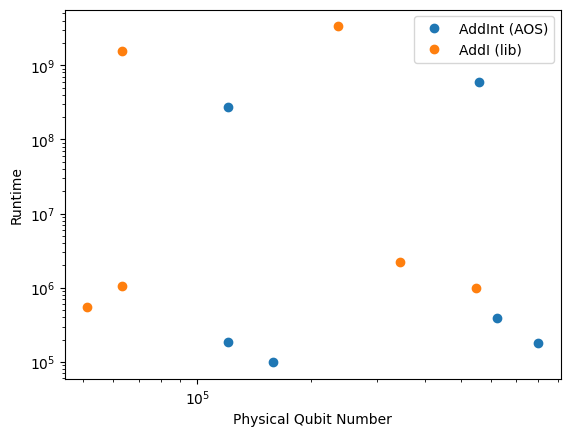

In [12]:
plot_figure(results_add, results_addint_lib_nomeasured, 'AddInt (AOS)', 'AddI (lib)')


In [13]:
#The multiplication2.ll is without the measurement
results_mul_nomeasured = estimate_resource( f_name="Multiplication2_nomeasured.ll", errorBudget=1e-4)
physical_qubits, runtime, volumn = analyze_results(results_mul_nomeasured)
print(physical_qubits)
print(runtime)
print(volumn)

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
[731596, 205964, 826236, 205964, 864376, 158984]
[3549600000, 1879200000, 2366400, 1252800, 939600, 522000]
[2596873161600000, 387047548800000, 1955204870400, 258031699200, 812167689600, 82989648000]


In [14]:
results_mul = estimate_resource( f_name="Multiplication2.ll")
physical_qubits, runtime, volumn = analyze_results(results_mul)
print(physical_qubits)
print(runtime)
print(volumn)

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
[718076, 202044, 799196, 202044, 798856, 156904]
[4192200000, 2219400000, 2794800, 1479600, 1109700, 616500]
[3010318207200000, 448416453600000, 2233592980800, 298944302400, 886490503200, 96731316000]


In [15]:
results_mul_lib = estimate_resource( f_name="Multiplication2_lib.ll", errorBudget=1e-4)
physical_qubits, runtime, volumn = analyze_results(results_mul_lib)
print(physical_qubits)
print(runtime)
print(volumn)

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
[333214, 73934, 513214, 73934, 613676, 90684]
[103192800000, 48880800000, 68795200, 32587200, 24440400, 13578000]
[34385285659200000, 3613953067200000, 35306659772800, 2409302044800, 14998486910400, 1231307352000]


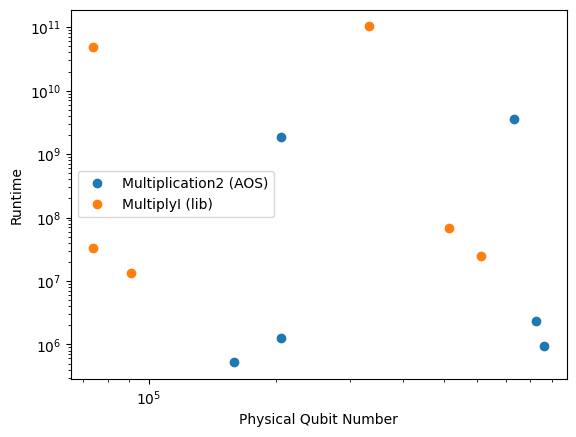

In [16]:
plot_figure(results_mul_nomeasured, results_mul_lib, 'Multiplication2 (AOS)', 'MultiplyI (lib)')

In [17]:
results_AMM= estimate_resource( f_name="AddMulMod.ll")
physical_qubits, runtime, volumn = analyze_results(results_AMM)
print(physical_qubits)
print(runtime)
print(volumn)
results_AMM_lib = estimate_resource( f_name="AddMulMod_lib.ll")
physical_qubits, runtime, volumn = analyze_results(results_AMM_lib)
print(physical_qubits)
print(runtime)
print(volumn)

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
[731596, 205964, 826236, 205964, 864376, 158984]
[4222800000, 2235600000, 2815200, 1490400, 1117800, 621000]
[3089383588800000, 460453118400000, 2326019587200, 306968745600, 966199492800, 98729064000]
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
[366952, 106272, 562632, 106272, 759408, 94512]
[96079200000, 45511200000, 64052800, 30340800, 22755600, 12642000]
[35256454598400000, 4836566246400000, 36038154969600, 3224377497600, 17280784684800, 1194820704000]


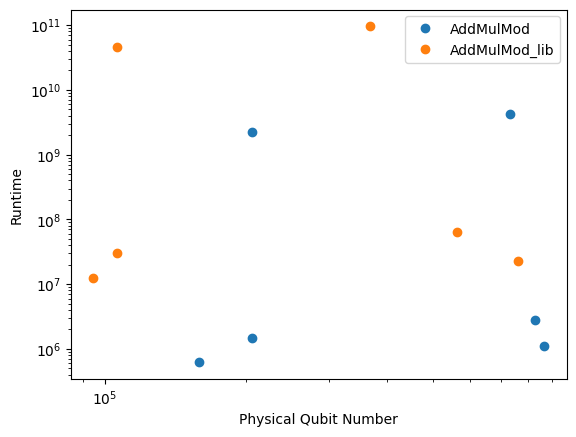

In [18]:
plot_figure(results_AMM, results_AMM_lib, 'AddMulMod', 'AddMulMod_lib')

The following resource estimation is using the halfing the addition T-gate method.

In [19]:
results_Maj= estimate_resource( f_name="majority.ll",  errorBudget=1e-5)
physical_qubits, runtime, volumn = analyze_results(results_Maj)
print(physical_qubits)
print(runtime)
print(volumn)
results_Maj_AA = estimate_resource( f_name="majority_AA.ll", errorBudget=1e-5)
physical_qubits, runtime, volumn = analyze_results(results_Maj_AA)
print(physical_qubits)
print(runtime)
print(volumn)

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
[107484, 31164, 208884, 31164, 484872, 19656]
[436800000, 235200000, 291200, 156800, 117600, 50400]
[46949011200000, 7329772800000, 60827020800, 4886515200, 57020947200, 990662400]
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
[73684, 21364, 141284, 21364, 310152, 13416]
[343200000, 184800000, 228800, 123200, 92400, 39600]
[25288348800000, 3948067200000, 32325779200, 2632044800, 28658044800, 531273600]


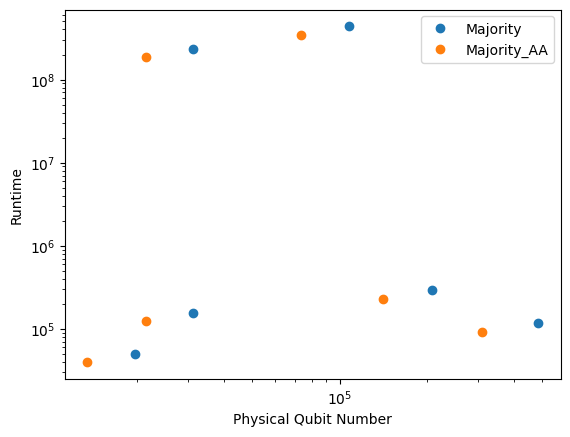

In [20]:
plot_figure(results_Maj, results_Maj_AA, 'Majority', 'Majority_AA')

In [21]:
results_AddInt_half = estimate_resource( f_name="AddInt_half.ll", errorBudget=1e-5)
physical_qubits, runtime, volumn = analyze_results(results_AddInt_half)
print(physical_qubits)
print(runtime)
print(volumn)

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
[704556, 200084, 772156, 200084, 755176, 155864]
[448800000, 237600000, 299200, 158400, 118800, 66000]
[316204732800000, 47539958400000, 231029075200, 31693305600, 89714908800, 10287024000]


In [22]:
results_addint_lib_nomeasured = estimate_resource( f_name="AddInt_lib_nomeasured_no_oracle.ll", errorBudget=1e-5)
physical_qubits, runtime, volumn = analyze_results(results_addint_lib_nomeasured)
print(physical_qubits)
print(runtime)
print(volumn)

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
[308730, 73610, 506730, 73610, 547380, 51140]
[3794400000, 2008800000, 2529600, 1339200, 1004400, 558000]
[1171445112000000, 147867768000000, 1281824208000, 98578512000, 549788472000, 28536120000]


In [23]:
# This addInt.ll is with the measurement and oracle initialization
results_addint = estimate_resource( f_name="AddInt.ll", errorBudget=1e-5)
physical_qubits, runtime, volumn = analyze_results(results_addint)
print(physical_qubits)
print(runtime)
print(volumn)

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
[684276, 192244, 731596, 192244, 645976, 152744]
[1315800000, 696600000, 877200, 464400, 348300, 193500]
[900370360800000, 133917170400000, 641756011200, 89278113600, 224993440800, 29555964000]


In [38]:
def plot_figure3(result1, result2, result3, label1, label2, label3, savfig=False, figname=None):
    plt.rcParams["figure.figsize"] = (10,5)
    # set the resolution of the figure
    plt.rcParams['figure.dpi'] = 100
    # set the font size of the figure
    plt.rcParams.update({'font.size': 13})
    
    for re, label in zip([result1, result2, result3], [label1, label2, label3]):
        physical_qubits, runtime, volumn = analyze_results(re)
        #plot volumn as bar chart in a different sub plot
        plt.subplot(1, 2, 1)
        plt.plot(physical_qubits, runtime, 'o', label=label)
        plt.xlabel('Physical Qubit (N)')
        plt.ylabel('Runtime (ms)')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlim(4e4, 2e6)
        plt.ylim(2e4, 2e11)

    physical_qubits1, runtime1, volumn1 = analyze_results(result1)
    physical_qubits2, runtime2, volumn2 = analyze_results(result2)
    physical_qubits3, runtime3, volumn3 = analyze_results(result3)    

    qubit_params = ["gate_us_e3", "gate_us_e4", "gate_ns_e3", "gate_ns_e4", "maj_ns_e4", "maj_ns_e6"]
    #plot a barchart for volumn
    plt.subplot(1, 2, 2)
    for i, q_p in zip( range(len(volumn1)), qubit_params):
        plt.bar([q_p+'Library'], volumn1[i], label='Q# Libraray', alpha=1, color='tab:blue')
        plt.bar([q_p+'AOS'], volumn2[i], label='AOS', alpha=1, color='tab:orange')
        plt.bar([q_p+'AOS(opt)'], volumn3[i], label='AOS(opt)', alpha=1, color='tab:green')
        if i < 5:
            plt.bar([q_p+' '],[0])
        if i == 0:
            plt.legend()
        plt.ylim(6e9, 8e16)

    # Only show x_ticks for every 4 bars 
    plt.xticks(np.arange(1, len(qubit_params)*4, 4), qubit_params)
    
    plt.xlabel('Qubit Parameters')
    plt.ylabel('volume (N*ms)')
    plt.yscale('log')
    plt.tight_layout()
    #rotate the bar label to make it more readable
    plt.xticks(rotation=45)
    
    # On shows the legends for the first 3 entry



    if savfig:
        plt.savefig( figname + '.pdf', dpi=300, bbox_inches='tight')
    
    
        


In [25]:
import matplotlib
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42

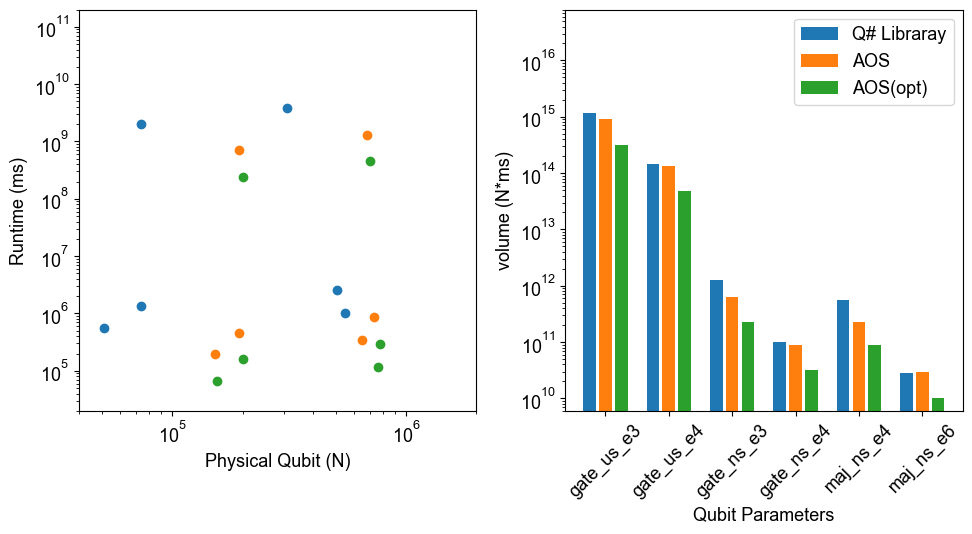

In [39]:
plot_figure3(results_addint_lib_nomeasured, results_addint, results_AddInt_half,  'Q# library', 'AOS', 'AOS (opt)', savfig=True, figname='AddInt')

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


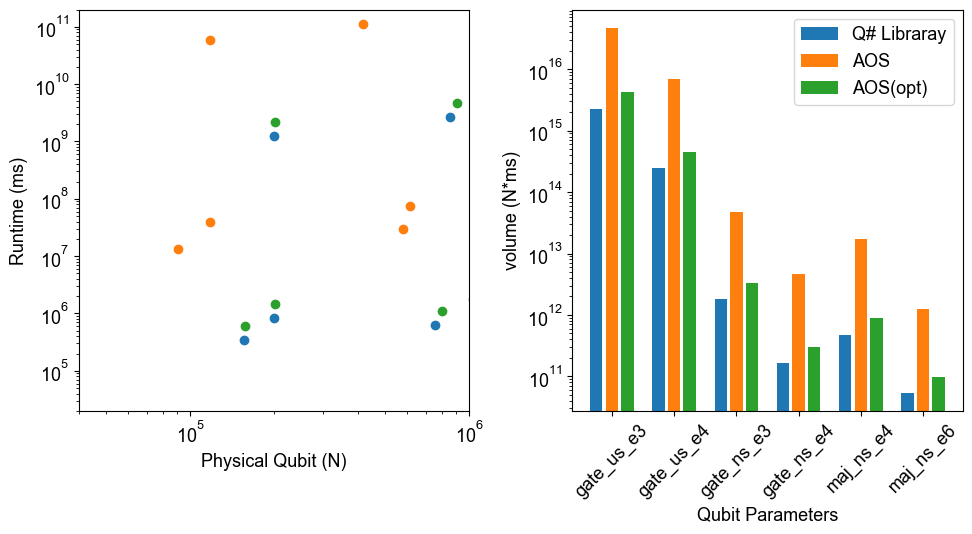

In [27]:
results_M2 = estimate_resource( f_name="Multiplication2.ll", errorBudget=1e-5)
physical_qubits, runtime, volumn = analyze_results(results_M2)
results_M2_half = estimate_resource( f_name="Multiplication2_half.ll", errorBudget=1e-5)
physical_qubits, runtime, volumn = analyze_results(results_M2_half)
results_M2_lib= estimate_resource( f_name="Multiplication2_lib.ll", errorBudget=1e-5)
physical_qubits, runtime, volumn = analyze_results(results_M2_lib)

plot_figure3(results_M2_half, results_M2_lib, results_M2, 'M2_half', 'M2_lib', 'M2')

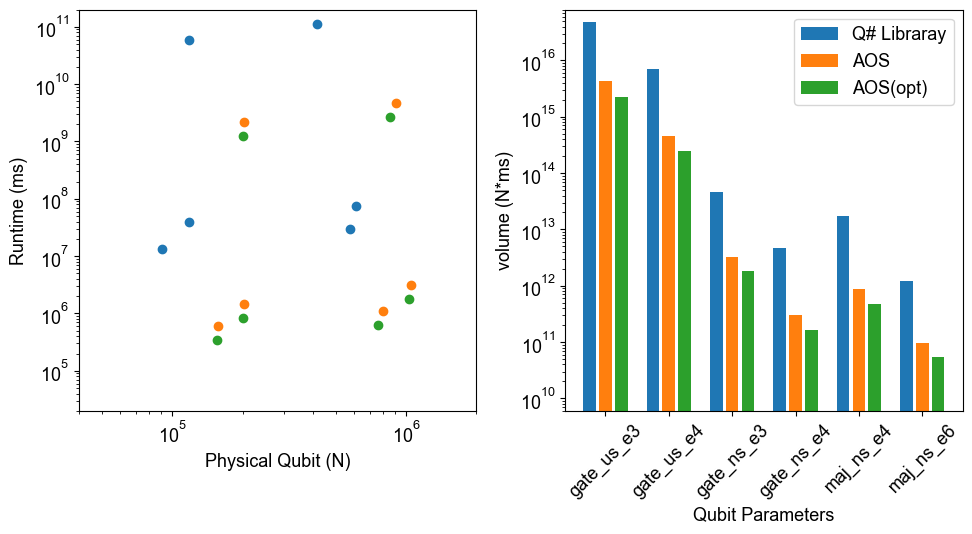

In [40]:
plot_figure3(results_M2_lib, results_M2, results_M2_half,   'Q# library',  'AOS', 'AOS (opt)', savfig=True, figname='Multiplication2')

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


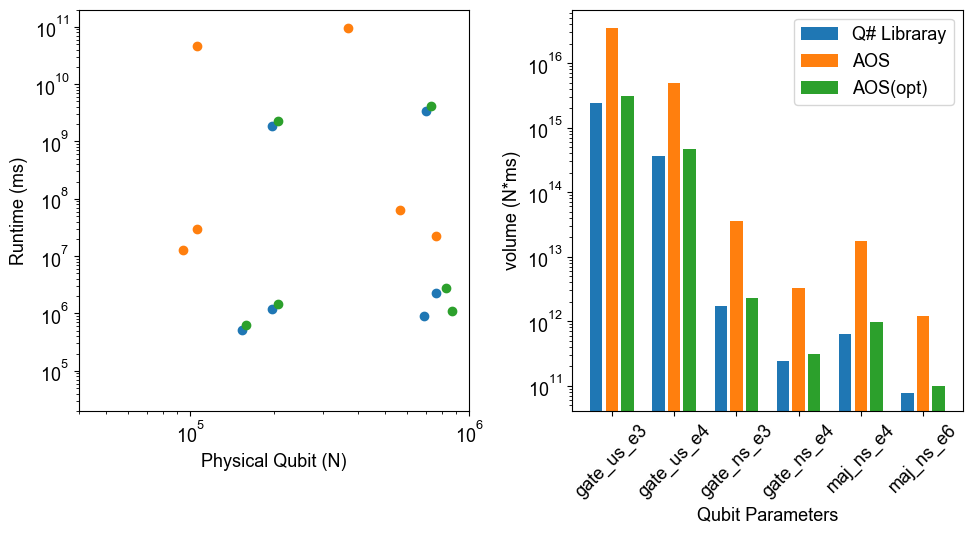

In [29]:
results_AMM = estimate_resource( f_name="AddMulMod.ll", errorBudget=1e-4)
results_AMM_half = estimate_resource( f_name="AddMulMod_half.ll", errorBudget=1e-4)
results_AMM_lib= estimate_resource( f_name="AddMulMod_lib.ll", errorBudget=1e-4)

plot_figure3(results_AMM_half, results_AMM_lib, results_AMM, 'AMM_half', 'AMM_lib', 'AMM')

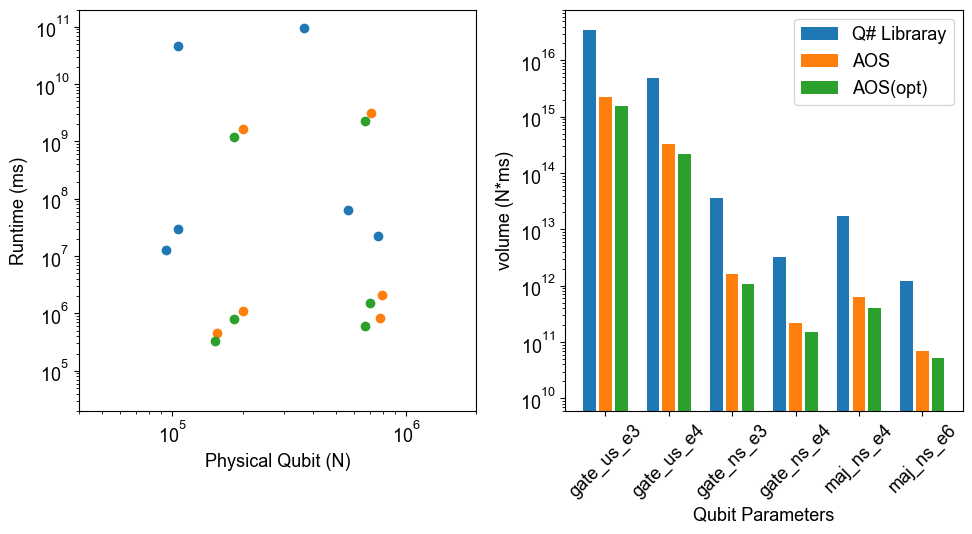

In [41]:
plot_figure3(results_AMM_lib, results_AMM, results_AMM_half,  'Q# library',  'AOS', 'AOS (opt)')

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


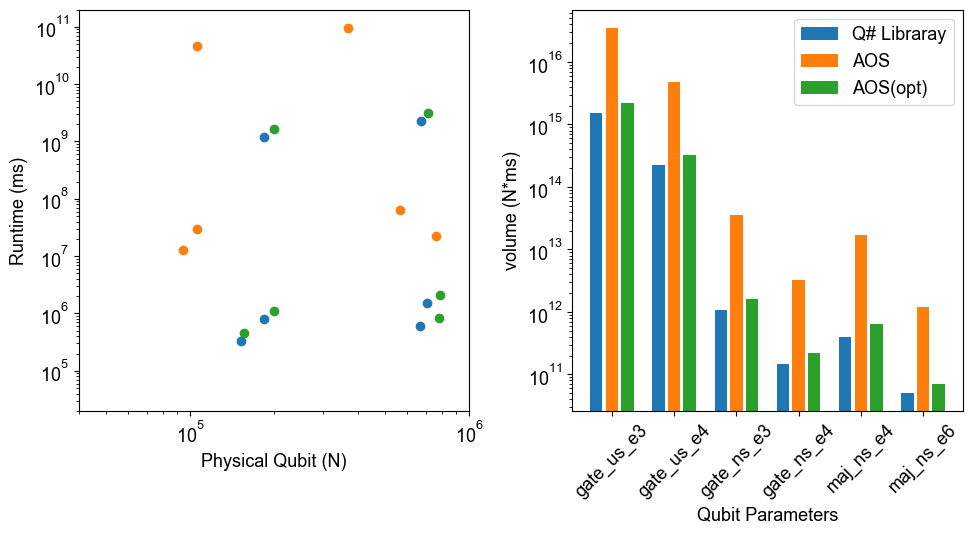

In [31]:
results_AMM = estimate_resource( f_name="AddMulMod_org_const.ll", errorBudget=1e-4)
results_AMM_half = estimate_resource( f_name="AddMulMod_MB_const.ll", errorBudget=1e-4)
results_AMM_lib= estimate_resource( f_name="AddMulMod_lib.ll", errorBudget=1e-4)

plot_figure3(results_AMM_half, results_AMM_lib, results_AMM, 'AMM_half', 'AMM_lib', 'AMM')

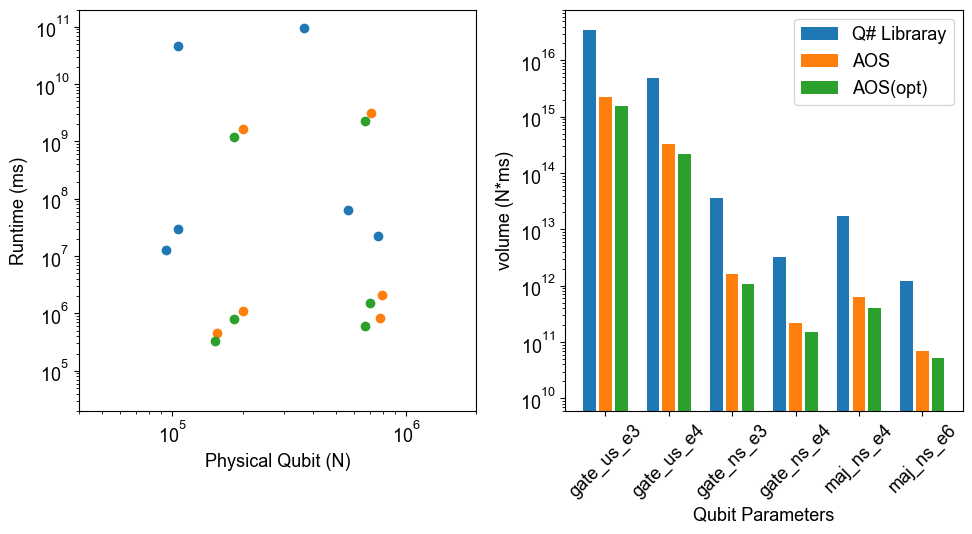

In [42]:
plot_figure3(results_AMM_lib, results_AMM, results_AMM_half,  'Q# library',  'AOS', 'AOS (opt)',  savfig=True, figname='AddMulMod')